In [1]:
#!/usr/bin/env python3
import soundfile as sf
import sounddevice as sd
import winsound
import numpy as np
import pyaudio
import math
import librosa
import time
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tflite_runtime.interpreter as tflite

In [8]:
block_len = 512
block_shift = 128
# # load model
# model = tf.saved_model.load('dtln_saved_model')
# infer = model.signatures["serving_default"]
inputAudio = r'D:\Noise Cancellation\Experimentation\dataset\traffic_sound.wav'
RATE = 16000
# # CHUNK = int(RATE/20) # RATE / number of updates per second

In [6]:
def soundplot(stream):
    t1=time.time()
    data = np.fromstring(stream.read(RATE),dtype=np.int16)
    return data

def start_stream(duration):
    da=[]
    p=pyaudio.PyAudio()
    stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True)
    for i in range(duration):
        #if i%10==0: print(i) 
#         print(i)
        d=soundplot(stream)
        da.append(soundplot(stream)) 
    stream.stop_stream()
    stream.close()
    p.terminate()
    print('Recording Completed')
    return np.array(da).reshape(-1)

def scaled(inputs,ranges):
    scaler = MinMaxScaler(feature_range=ranges)
    foo = scaler.fit_transform(inputs.reshape(-1,1))
    return foo,scaler

def get_noise_from_sound(signal,noise,SNR):
    RMS_s=math.sqrt(np.mean(signal**2))
    #required RMS of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    
    #current RMS of noise
    RMS_n_current=math.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    
    return noise

def mixer(clean,noisy,snr,scaler):
    if(len(noisy)>len(clean)):
        noisy=noisy[0:len(clean)] 
    noisy = get_noise_from_sound(clean,noisy,SNR=snr)
    mixed = clean+noisy
    if scaler != None:
        mixed = scaler.inverse_transform(mixed)
    return mixed
    

def cleanup(audio):
    interpreter_1 = tflite.Interpreter(model_path='pretrained_models/model_1.tflite')
    interpreter_1.allocate_tensors()
    interpreter_2 = tflite.Interpreter(model_path='pretrained_models/model_2.tflite')
    interpreter_2.allocate_tensors()

    # Get input and output tensors.
    input_details_1 = interpreter_1.get_input_details()
    output_details_1 = interpreter_1.get_output_details()

    input_details_2 = interpreter_2.get_input_details()
    output_details_2 = interpreter_2.get_output_details()
    # create states for the lstms
    states_1 = np.zeros(input_details_1[1]['shape']).astype('float32')
    states_2 = np.zeros(input_details_2[1]['shape']).astype('float32')
    # preallocate output audio
    out_file = np.zeros((len(audio)))
    # create buffer
    in_buffer = np.zeros((block_len)).astype('float32')
    out_buffer = np.zeros((block_len)).astype('float32')
    # calculate number of blocks
    num_blocks = (audio.shape[0] - (block_len-block_shift)) // block_shift
    time_array = []      
    # iterate over the number of blcoks        
    for idx in range(num_blocks):
        start_time = time.time()
        # shift values and write to buffer
        in_buffer[:-block_shift] = in_buffer[block_shift:]
        in_buffer[-block_shift:] = audio[idx*block_shift:(idx*block_shift)+block_shift]
        # calculate fft of input block
        in_block_fft = np.fft.rfft(in_buffer)
        in_mag = np.abs(in_block_fft)
        in_phase = np.angle(in_block_fft)
        # reshape magnitude to input dimensions
        in_mag = np.reshape(in_mag, (1,1,-1)).astype('float32')
        # set tensors to the first model
        interpreter_1.set_tensor(input_details_1[1]['index'], states_1)
        interpreter_1.set_tensor(input_details_1[0]['index'], in_mag)
        # run calculation 
        interpreter_1.invoke()
        # get the output of the first block
        out_mask = interpreter_1.get_tensor(output_details_1[0]['index']) 
        states_1 = interpreter_1.get_tensor(output_details_1[1]['index'])   
        # calculate the ifft
        estimated_complex = in_mag * out_mask * np.exp(1j * in_phase)
        estimated_block = np.fft.irfft(estimated_complex)
        # reshape the time domain block
        estimated_block = np.reshape(estimated_block, (1,1,-1)).astype('float32')
        # set tensors to the second block
        interpreter_2.set_tensor(input_details_2[1]['index'], states_2)
        interpreter_2.set_tensor(input_details_2[0]['index'], estimated_block)
        # run calculation
        interpreter_2.invoke()
        # get output tensors
        out_block = interpreter_2.get_tensor(output_details_2[0]['index']) 
        states_2 = interpreter_2.get_tensor(output_details_2[1]['index']) 


        # shift values and write to buffer
        out_buffer[:-block_shift] = out_buffer[block_shift:]
        out_buffer[-block_shift:] = np.zeros((block_shift))
        out_buffer  += np.squeeze(out_block)
        # write block to output file
        out_file[idx*block_shift:(idx*block_shift)+block_shift] = out_buffer[:block_shift]
        time_array.append(time.time()-start_time)
    return out_file

In [14]:
# recordAudio = start_stream(5)
noiseAudio, sampleRate = librosa.load(inputAudio, sr=16000)

if sampleRate != 16000:
    raise ValueError('This model only supports 16k sampling rate.')

cleanAudio,cleanScaler = scaled(recordAudio,(-1,1))
noiseAudio,noiseScaler = scaled(noiseAudio,(-1,1))
mixedAudio = mixer(cleanAudio,noiseAudio,10,None)

outAudio = cleanup(np.squeeze(mixedAudio))

In [15]:
print('Playing the noisy sound')
sd.play(mixedAudio,sampleRate)

Playing the noisy sound


In [16]:
print('Playing the cleaned sound')
sd.play(outAudio,sampleRate)

Playing the cleaned sound


In [26]:
input()

Hello


'Hello'

In [7]:
winsound.PlaySound(inputAudio, winsound.SND_FILENAME)

In [8]:
audio.shape

(160000,)

In [9]:
if fs != 16000:
    raise ValueError('This model only supports 16k sampling rate.')
# preallocate output audio
out_file = np.zeros((len(audio)))
# create buffer
in_buffer = np.zeros((block_len))
out_buffer = np.zeros((block_len))
# calculate number of blocks
num_blocks = (audio.shape[0] - (block_len-block_shift)) // block_shift
# iterate over the number of blcoks        
for idx in range(num_blocks):
    # shift values and write to buffer
    in_buffer[:-block_shift] = in_buffer[block_shift:]
    in_buffer[-block_shift:] = audio[idx*block_shift:(idx*block_shift)+block_shift]
    # create a batch dimension of one
    in_block = np.expand_dims(in_buffer, axis=0).astype('float32')
    # process one block
    out_block= infer(tf.constant(in_block))['conv1d_1']
    # shift values and write to buffer
    out_buffer[:-block_shift] = out_buffer[block_shift:]
    out_buffer[-block_shift:] = np.zeros((block_shift))
    out_buffer  += np.squeeze(out_block)
    # write block to output file
    out_file[idx*block_shift:(idx*block_shift)+block_shift] = out_buffer[:block_shift]
    
    
# write to .wav file 
sf.write(r'D:\Noise Cancellation\Experimentation\dataset\out.wav', out_file, fs) 

print('Processing finished.')

Processing finished.


In [6]:
sys.maxsize**10

4455508415646675013373597242420117818453694838130159772560668808816707086990958982033203334310070688731662890013605553436739351074980172000127431349940128178077122187317837794167991459381249

In [4]:
if __name__=="__main__":
    da=[]
    p=pyaudio.PyAudio()
    stream=p.open(format=pyaudio.paInt16,channels=1,rate=RATE,input=True,
                  frames_per_buffer=CHUNK)
    for i in range(4):
        #if i%10==0: print(i) 
        print(i)
        d=soundplot(stream)
        da.append(soundplot(stream)) 
    stream.stop_stream()
    stream.close()
    p.terminate()

0


<ipython-input-3-758be9e77676>:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(stream.read(RATE),dtype=np.int16)


1
2
3


In [5]:
da=np.array(da)
da.shape

(4, 16000)

In [6]:
da1 = da.reshape(-1)

In [7]:
da1.shape

(64000,)

In [8]:
import sounddevice as sd

In [9]:
sd.play(da1,16000)

In [13]:
inputAudio = r'D:\Noise Cancellation\Experimentation\dataset\traffic_sound.wav'
# audio,fs = sf.read(inputAudio)
# print(fs)

In [19]:
audio.shape

(2919464, 2)

In [20]:
import matplotlib.pyplot as plt

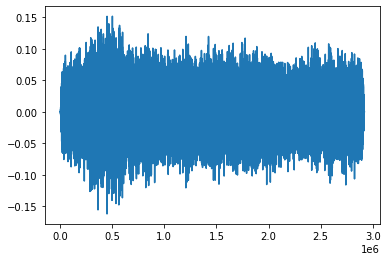

In [22]:
plt.plot(audio[:,0])

In [11]:
import librosa

In [14]:
 # Downsample 44.1kHz to 8kHz

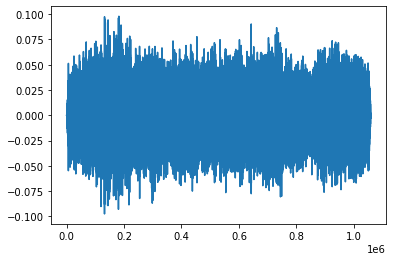

In [15]:
plt.plot(y)

In [16]:
sd.play(y[:len(da1)],16000)

In [17]:
sd.stop()

In [18]:
y.shape

(1059216,)

In [19]:
da1.shape

(64000,)

In [31]:
foo.shape

(64000, 1)

In [33]:
foo.max()

1.0

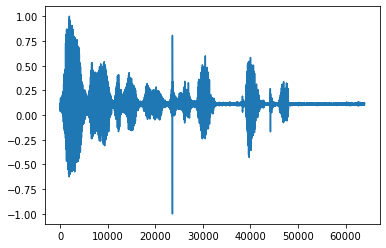

In [34]:
plt.plot(foo)

In [35]:
sd.play(foo,16000)

In [27]:
cleanAudio = 2*((da1 - da1.min())/(da1.max()-da1.min())) - 1
noiseAudio = 2*((y - y.min())/(y.max()-y.min())) - 1

<ipython-input-27-38621ec63bd0>:1: RuntimeWarning: overflow encountered in short_scalars
  cleanAudio = 2*((da1 - da1.min())/(da1.max()-da1.min())) - 1


In [24]:
cleanAudio.min(),cleanAudio.max()

(-2.1937730164044194, 2.1939738868429863)

In [22]:
noiseAudio.min(),noiseAudio.max()

(-1.0, 1.0)

In [25]:
da1.min(),da1.max()

(-28118, 22483)

In [28]:
type(da1)

numpy.ndarray

In [26]:
y.min(),y.max()

(-0.097506896, 0.097912826)

In [45]:
noisy_sound = da1 + y[:len(da1)]
noisy_sound.shape

(64000,)

In [38]:
sd.play(noisy_sound,16000)

In [ ]:
sd.stop()

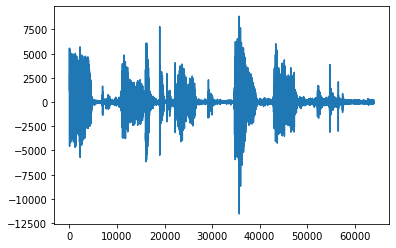

In [42]:
plt.plot(da1)

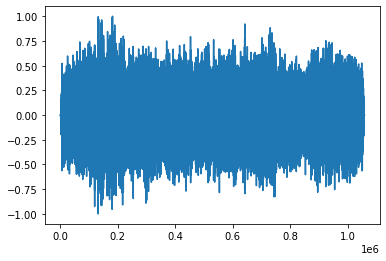

In [36]:
plt.plot(noiseAudio)

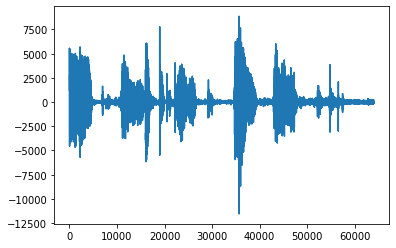

In [46]:
plt.plot(noisy_sound)

In [47]:
sf.write(r'D:\Noise Cancellation\Experimentation\dataset\out.wav', noisy_sound, 16000) 

y \--> noise\\
da1 \---> actual sound

In [48]:
y.min(),y.max()

(-0.097506896, 0.097912826)

In [49]:
da1.min(),da1.max()

(-11552, 8866)

In [69]:
cleanAudio = np.interp(da1, (da1.min(), da1.max()), (-1, 1))
noiseAudio = np.interp(y, (y.min(), y.max()), (-1, 1))

In [71]:
noiseAudio.shape,cleanAudio.shape

((64000,), (64000,))

In [37]:
import math


In [48]:
sd.play(noiseAudio1,16000)

In [49]:
sd.stop()

In [87]:
print("SNR = " + str(20*np.log10(math.sqrt(np.mean(cleanAudio**2))/math.sqrt(np.mean(noiseAudio1**2)))))

SNR = 9.999999999999998


In [43]:
sd.play(mixedAudio,16000)

In [90]:

    
    
# write to .wav file 
sf.write(r'D:\Noise Cancellation\Experimentation\dataset\out.wav', out_file, fs) 

print('Processing finished.')

Processing finished.


In [94]:
mixedAudio.max()

1.0066605477288868